In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
import heapq
from scipy.sparse.csgraph import floyd_warshall
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics.pairwise import paired_distances

def contactToDist(contactMat, alpha):
    """Convert contact matrix to distance matrix."""
    distMat = np.zeros_like(contactMat)
    numRows = len(contactMat)
    for i in range(numRows):
        for j in range(numRows):
            if contactMat[i,j] != 0 and i != j:
                distMat[i,j] = contactMat[i,j]**(-alpha)
            if distMat[i,j] > 100:
                distMat[i,j] = 0
    newDistMat = csr_matrix(distMat)
    pathMat = floyd_warshall(csgraph=newDistMat, directed=False)
    where_are_inf = np.isinf(pathMat)
    pathMat[where_are_inf] = 0
    return pathMat

def generateGraph(dist, k, res):
    """From distance matrix to get radius neighbors classifier."""
    graph = np.full_like(dist, 5, dtype=np.double)
    n = len(dist)
    for i in range(n):
        mask = dist[i]!=0
        neighbor = heapq.nsmallest(k, dist[i][mask])
        for j in range(n):
            if len(neighbor)==0 or dist[i,j] <= neighbor[-1]:
                graph[i,j] = dist[i,j]
    return graph

def clusterGraph(dist, eps, min_samples):
    """Use cluster from distance matrix to generate hypergraph."""
    db = DBSCAN(eps=eps, min_samples=min_samples,metric="cosine").fit(dist)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    x = []
    X = []
    for i in range(len(labels)):
        if labels[i] != -1:
            X.append(dist[i])
            x.append(labels[i])
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, x))
    return labels

def boundaryPlot(labels):
    n = len(labels)
    boundary = np.zeros(n)
    i = 0
    label = 0
    start = 0
    while i < n:
        if labels[i] != -1:
            if labels[i] == label:
                boundary[i] = start
            else:
                start = i
                label = labels[i]
                boundary[i] = start
        else:
            boundary[i] = i
            label = -1
        i = i + 1
    return boundary

# DBSCAN parameters selection
def epsSelection(graph):
    mask = ~(graph==0).all(1)
    data = graph[mask]
    n = len(data)
    eps_distance = paired_distances(data[0: n-1], data[1 : n],metric="cosine")
    return eps_distance


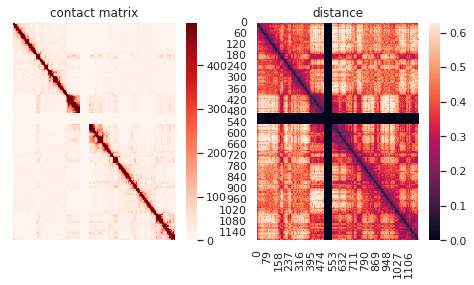

In [106]:
hic=np.loadtxt("../GM12878/chr19_50kb/chr19_50000.hic")
name = "chr19"
res = 5000
dist = contactToDist(hic, 0.3)
np.savetxt("{}_{}.dist".format(name, res), dist)
# dist = np.loadtxt("chr19_5000.dist")


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.set_theme(style="white")
sns.heatmap(hic, robust=True, cmap="Reds", xticklabels=False, yticklabels=False)
plt.title('contact matrix')

plt.subplot(1,2,2)
sns.heatmap(dist, robust=True)
plt.title('distance')

plt.show()

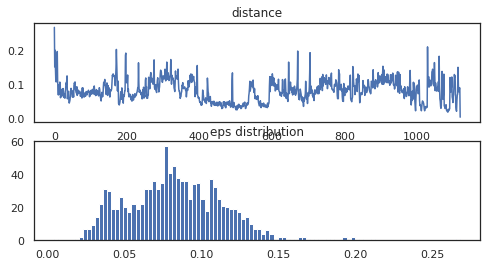

In [141]:
res = 50000
graph = generateGraph(dist, 500, res)
eps_selecte = epsSelection(graph)
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
axes[0].plot(eps_selecte)
axes[0].set_title('distance')
axes[1].hist(eps_selecte, bins=100)
axes[1].set_title('eps distribution')
plt.show()

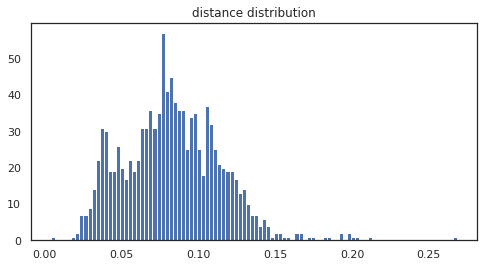

In [142]:
eps_selecte = epsSelection(graph)
fig, axes = plt.subplots(figsize=(8, 4))
axes.hist(eps_selecte, bins=100)
axes.set_title('distance distribution')
plt.show()
eps_selecte = eps_selecte.tolist()

Estimated number of clusters: 16
Estimated number of noise points: 435
Silhouette Coefficient: 0.220


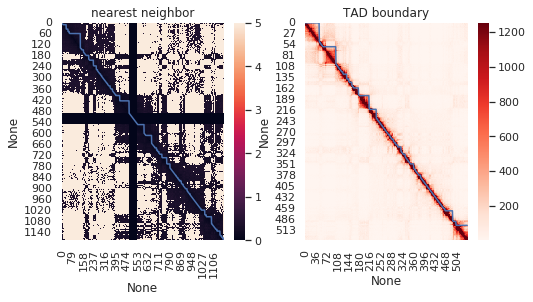

In [143]:
labels = clusterGraph(graph,0.082,3)
tads = boundaryPlot(labels)

outpath = "../GM12878/chr19_50kb/TAD/DBSCAN_1.txt"
i = 0
with open(outpath, "w") as out:
    while i < len(tads):
        if tads[i] < i:
            start = i - 1
            while i < len(tads) and tads[i] == start:
                end = i
                i = i + 1
            if end-start>=2:
                startbin = start * res
                endbin = end * res
                out.write("\t".join((str(start), str(startbin), str(end), str(endbin))) + "\n")
        i = i + 1
    out.close()
        
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sns.heatmap(data=graph)
sns.lineplot(data=tads)
plt.title('nearest neighbor')

plt.subplot(1,2,2)
sns.heatmap(data=hic[553:1091,553:1091], robust=True, cmap="Reds")
sns.lineplot(data=[round(tad - 553) for tad in tads][553:1091])
plt.title('TAD boundary')

plt.show()

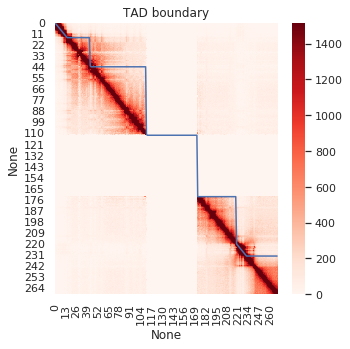

In [8]:
plt.figure(figsize=(5,5))

sns.heatmap(data=hic[380:650,380:650], robust=True, cmap="Reds")
sns.lineplot(data=[round(tad - 380) for tad in tads][380:650])
plt.title('TAD boundary')

plt.show()

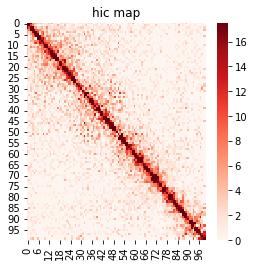

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
# data = np.loadtxt("../chr21_5kb/chr21_5000.hic")
plt.figure(figsize=(4,4))

sns.heatmap(data=data[2000:4000:20,2000:4000:20], robust=True, cmap="Reds")
plt.title('hic map')

plt.show()